In [2]:
import os
import numpy as np
from scipy.io import loadmat
import pandas as pd
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import json
from sklearn.metrics import mean_squared_error
from collections import defaultdict

In [11]:
def cargar_vectores_agarre(carpeta, key_ejercicio, emg_key='emg'):
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.mat') and key_ejercicio in f]
    vectores = [] 
    for archivo in archivos[:2]:
        path = os.path.join(carpeta, archivo)
        data = loadmat(path)
        emg = data[emg_key] # Señal EMG cruda
        print(emg)
        # Calcular RMS sobre la señal ya limpia
        vec = np.sqrt(np.mean(np.square(emg), axis=0))
        vectores.append(vec)
        
    return vectores, archivos

In [12]:
db1_path = './utils/ninaproDB1/'
db2_path = './utils/ninaproDB2/'

db1_bottle_key = 'E2'
db2_bottle_key = 'E1_A1'

vectores_db1, archivos_db1 = cargar_vectores_agarre(db1_path, db1_bottle_key)
vectores_db2, archivos_db2 = cargar_vectores_agarre(db2_path, db2_bottle_key)

norm_db1 = None
norm_db2 = None

if vectores_db1:
    ideal_db1 = np.median(vectores_db1, axis=0)
    norm_db1 = (ideal_db1 - ideal_db1.min()) / (ideal_db1.max() - ideal_db1.min())
    print("\nAgarre ideal bottle (DB1, normalizado):\n", np.round(norm_db1, 3))
    print("Archivos usados DB1:", archivos_db1)

if vectores_db2:
    ideal_db2 = np.median(vectores_db2, axis=0)
    norm_db2 = (ideal_db2 - ideal_db2.min()) / (ideal_db2.max() - ideal_db2.min())
    print("\nAgarre ideal bottle (DB2, normalizado):\n", np.round(norm_db2, 3))
    print("Archivos usados DB2:", archivos_db2)

max_channels = max(len(norm_db1) if norm_db1 is not None else 0, len(norm_db2) if norm_db2 is not None else 0)
rows = []
for i in range(max_channels):
    ch_name = f'ch{i}'
    db1_val = round(norm_db1[i], 3) if norm_db1 is not None and i < len(norm_db1) else None
    db2_val = round(norm_db2[i], 3) if norm_db2 is not None and i < len(norm_db2) else None
    rows.append({'Canal': ch_name, 'DB1': db1_val, 'DB2': db2_val})

df = pd.DataFrame(rows)
print("\nTabla comparativa de agarre ideal (bottle) DB1 vs DB2:\n")
print(df)

df.to_csv('agarre_ideal_bottle_comparacion.csv', index=False)

print(df.to_markdown(index=False))

[[0.0024 0.0024 0.0024 ... 0.0464 0.0024 0.0098]
 [0.0024 0.0024 0.0024 ... 0.0513 0.0024 0.0171]
 [0.0024 0.0024 0.0024 ... 0.0488 0.0024 0.022 ]
 ...
 [0.0024 0.0024 0.0024 ... 0.0171 0.0024 0.0024]
 [0.0024 0.0024 0.0024 ... 0.0195 0.0024 0.0024]
 [0.0024 0.0024 0.0024 ... 0.0195 0.0024 0.0024]]
[[0.0684 0.0024 0.0024 ... 0.2588 0.0024 0.1563]
 [0.0732 0.0024 0.0024 ... 0.2979 0.0024 0.1611]
 [0.0757 0.0024 0.0024 ... 0.3296 0.0024 0.1978]
 ...
 [0.0024 0.1172 0.0024 ... 0.2271 0.0171 0.1343]
 [0.0024 0.1099 0.0073 ... 0.2319 0.0171 0.1367]
 [0.0024 0.1221 0.0098 ... 0.2319 0.0146 0.1465]]
[[ 9.5976829e-06 -2.1171449e-07 -1.3632009e-06 ... -1.5272371e-05
   1.2388873e-06 -2.4777496e-06]
 [ 5.1150118e-06  1.6835917e-06  1.0286180e-06 ... -1.3781581e-05
   2.1909293e-06  4.5988040e-06]
 [ 2.3048872e-06 -1.4512199e-06  4.0372042e-06 ... -1.0432202e-05
   5.2410064e-06  1.0603334e-05]
 ...
 [-8.3563264e-06  4.3595373e-06  5.6613692e-07 ...  2.3111490e-07
  -2.9962257e-06  3.3865197e-06]

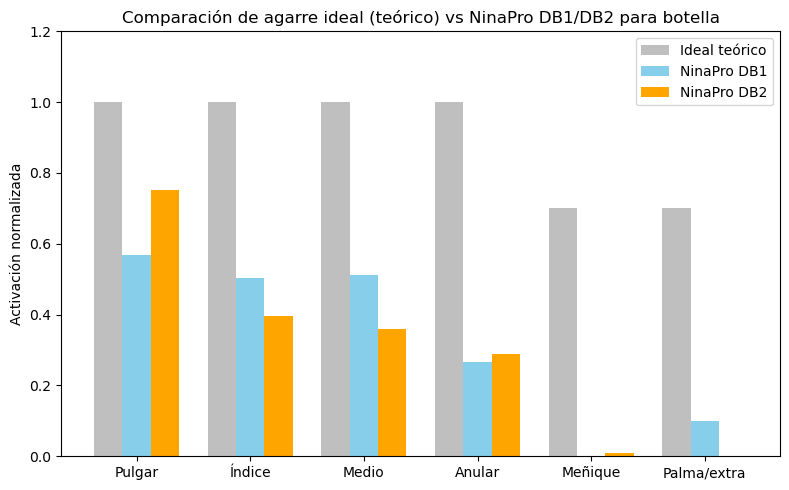

In [10]:
dedos = ["Pulgar", "Índice", "Medio", "Anular", "Meñique", "Palma/extra"]

agarre_ideal_real = [1, 1, 1, 1, 0.7, 0.7]
agarre_ninapro_db1 = norm_db1[:6]  # tus valores reales DB1
agarre_ninapro_db2 = norm_db2[:6]  # tus valores reales DB2

x = np.arange(len(dedos))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, agarre_ideal_real, width, label="Ideal teórico", color='gray', alpha=0.5)
plt.bar(x, agarre_ninapro_db1, width, label="NinaPro DB1", color='skyblue')
plt.bar(x + width, agarre_ninapro_db2, width, label="NinaPro DB2", color='orange')
plt.xticks(x, dedos)
plt.ylabel("Activación normalizada")
plt.ylim(0, 1.2)
plt.title("Comparación de agarre ideal (teórico) vs NinaPro DB1/DB2 para botella")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
dedos_order = ["upper_thumb", "lower_thumb", "index_finger", "middle_finger", "ring_finger", "pinky_finger"]

def extract_llm_vector(response):
    moves = response.get('hand_movements', [])
    if isinstance(moves, str):
        moves_clean = moves.strip('`').strip()
        try:
            moves = json.loads(moves_clean)
        except json.JSONDecodeError:
            return [0]*len(dedos_order)

    if isinstance(moves, list) and len(moves) == 1 and isinstance(moves[0], list):
        moves = moves[0]

    dedo_map = {d['engine']: d['value'] for d in moves if isinstance(d, dict) and 'engine' in d and 'value' in d}
    return [dedo_map.get(d, 0) for d in dedos_order]

In [6]:
model_llm_emg_vectors = defaultdict(list)
for resp in responses_emg_llm:  
    model = resp.get("llm_model", "unknown")
    vec = extract_llm_vector(resp)
    if len(vec) == len(dedos_order):
        model_llm_emg_vectors[model].append(vec)

ideal_vector = np.array([1, 1, 1, 1, 0.7, 0.7])

precisions_per_model = {}
for model, vectors in model_llm_emg_vectors.items():
    mses = [mean_squared_error(ideal_vector, vec) for vec in vectors]
    precisions = [100 * (1 - mse) for mse in mses]
    precisions_per_model[model] = precisions

plt.figure(figsize=(12, 8))
positions = range(len(precisions_per_model))

plt.boxplot(list(precisions_per_model.values()), positions=positions, patch_artist=True)

plt.xticks(positions, precisions_per_model.keys(), rotation=45, ha='right')
plt.ylabel('Precisión respecto al ideal (%)')
plt.title('Precisión de comandos motores generados por cada modelo LLM (visión + EMG)')

plt.axhline(100, color='r', linestyle='--', label='Ideal teórico (100%)')

plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

NameError: name 'responses_emg_llm' is not defined